In [2]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from functions_ import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from characterization_from_blast_alignments import *

In [1]:
## reload the evaluation functions
from importlib import reload 
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *

In [14]:
### define the necessary variables

base_dir = os.getcwd() 

catch_left = ''
catch_right = ''

Barcodes = {"BC1_fwd": "CCC", 
            "BC1_rev" : "CCC", 
            "BC2_fwd":	"AAA",
            "BC2_rev":	"AAA", 
            "BC3_fwd":	"TTT",
            "BC3_rev":	"TTT",}

Primer_seq = {"_fwd": "cgccgCATGGAAGCGAT".upper(),
              "_rev":"cgcacgCGGTTATCCATCG".upper()}

Primer_out_of_triplets = {"_fwd": 0, 
                          "_rev": 2}
amplicon_seq = "cgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcg".upper()

amplicon_AA = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [185]:
variant = "R36"
BCs_per_var = {"R35": ["BC1", "BC2"],
               "R36": ["BC1", "BC2", "BC3"],
               }

In [186]:

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
ref_gene = amplicon_seq

used_BCs = BCs_per_var[variant]

filter_for_n_mut = False# True
read_len_treshold = None#(40,40)

## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities, base_dir = f"{os.getcwd()}/data/fastq/{variant}"
)

all_reads, all_ids = demultiplex_reads(a_seq, b_seq, ref_gene = ref_gene ,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = used_BCs, Sections = [""], max_mismatch_primerseq = 5, filter_for_n_mut = filter_for_n_mut, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= read_len_treshold, Primer_out_of_triplets= Primer_out_of_triplets, cut_primer_start=True, cut_BC_seq=True)


#### settings
amplicon_DNA = amplicon_seq[:-2]
amplicon_AA = translate_dna2aa(amplicon_DNA)

### set parameters
base_dir = os.getcwd()
name = variant
FigFolder =f"{base_dir}/output/{name}/R1-R2"
use_rev_read = True
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False

if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

total reads 85274
[3, 5, 6, 11, 12, 14, 18, 20, 23, 24]
41699
2324 b reads are empty
702 a reads are empty
34446 forward reads with matching BC and primer seq
15012 reads with index swapping
BC1  34446 reads before filtering
################# Done: BC1 
################# Done: BC1
[0, 1, 2, 4, 7, 8, 9, 10, 15, 17]
26509
1951 b reads are empty
209 a reads are empty
21158 forward reads with matching BC and primer seq
13269 reads with index swapping
BC2  21158 reads before filtering
################# Done: BC2 
################# Done: BC2
[13, 16, 19, 21, 22, 31, 41, 44, 56, 71]
11759
852 b reads are empty
85 a reads are empty
8452 forward reads with matching BC and primer seq
7610 reads with index swapping
BC3  8452 reads before filtering
################# Done: BC3 
################# Done: BC3


In [ ]:
# Bc = "BC3"
# Read_dir = "R2"
# seqs = all_reads[f"{Bc}__{Read_dir}"]
# reads = all_reads[f"{Bc}__{Read_dir}"] if Read_dir == "R1" else [dna_rev_comp(r) for r in all_reads[f"{Bc}__{Read_dir}"]]

# output_file = f"data/fastq/{variant}/{variant}_{Bc}_Nt_filt_{Read_dir}_001.fasta"
# sequences = [SeqIO.SeqRecord(Seq(read), id = all_ids[f"{Bc}__{Read_dir}"][i], description = f"{variant} {Bc} DNA sequence") for i, read in enumerate(reads)]

# count = SeqIO.write(sequences, output_file, "fasta")
# with open(output_file, "w") as output_handle:
#     SeqIO.write(sequences, output_handle, "fasta")
# print("Saved %i records to %s" % (count, output_file))

In [187]:
same_bc = 0
diff_bc = 0
for idx, a_read in enumerate(a_seq): 
    if a_read[:3] == b_seq[idx][:3] and a_read[:3] != "":
        same_bc += 1  
    else: 
        diff_bc += 1
        
print("same BC: ", same_bc)
print("idx swapping BC: ", diff_bc)
print(diff_bc/(same_bc+diff_bc), " of reads have swapped BCs") #0.23862062377609017 0.24850481975748762

same BC:  64083
idx swapping BC:  21191
0.24850481975748762  of reads have swapped BCs


In [218]:
a_seq = all_reads["BC1__R1"]
b_seq = all_reads["BC1__R2"]

In [3]:
import json

Bc = "BC1"
read_dir = "R2"
variant = "R36"
homedir = "/home/student/anna/DMS_analysis/data/fastq/R36/"
base_dir = os.getcwd()

# Open the JSON file and load it as a dictionary
with open(f"{homedir}/blast/alignments/{variant}_{Bc}_S1_Nt_filt_{read_dir}.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>

with open(f"{homedir}/config.json") as f:
    config = json.load(f)


FigFolder = f"{base_dir}/output/{variant}/blast/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

amplicon_seq = config["amplicon"]

blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
LOV_startseq = "ttagcca".upper()
LOV_endseq = "ggccaaa".upper()


LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()



LOV2_startidx = amplicon_seq.index(LOV_startseq)
LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)


<class 'dict'>


In [4]:
### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

#strand = blast_alignments[0]["hsps"][0]["hit_strand"] # "Minus" or "Plus"
filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


28417 alignments before filtering for LOV2 insertion site
16469 alignments after filtering for LOV2 insertion site


In [5]:
cut_site_seq = LOV_startseq if read_dir=="R1" else LOV_endseq

linker_alignments, LOV2_alignments = divide_alignments(blast_alignments, cut_site_seq, read_dir=read_dir)
    

60 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)


699 sequences with off target indels are excluded
15710 sequences are included in the enrichment analysis


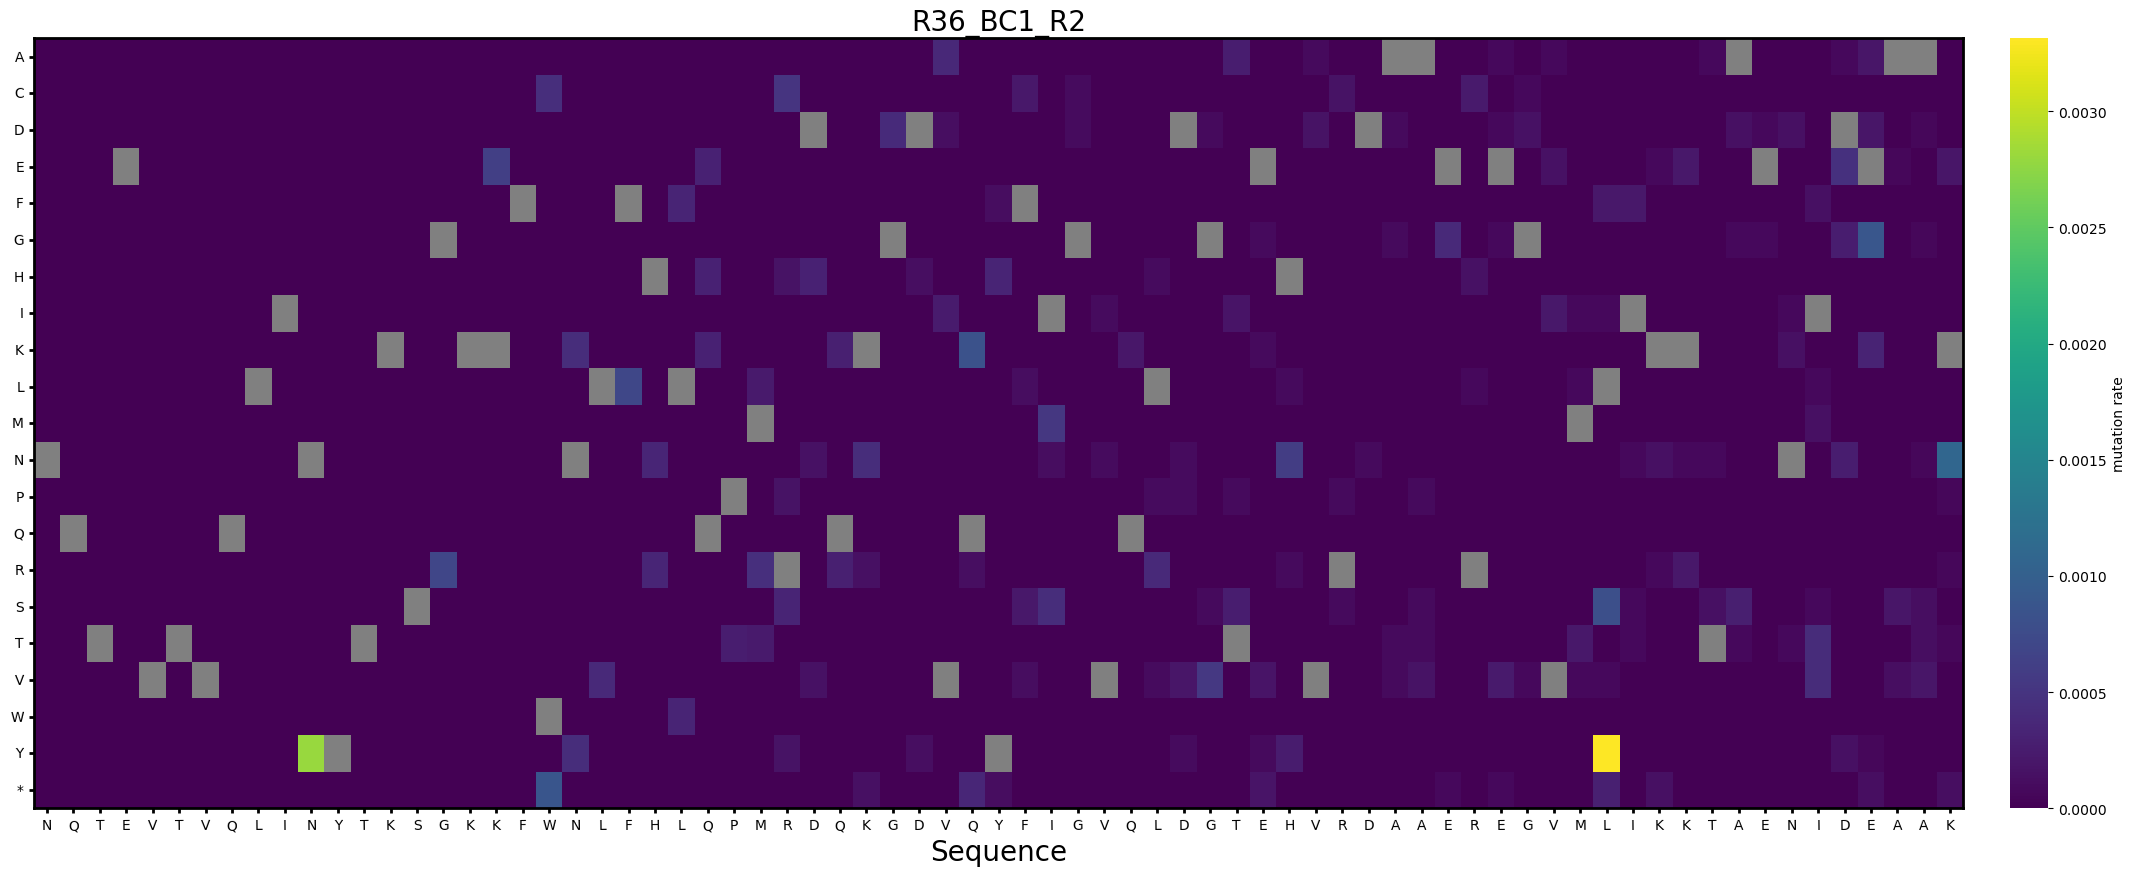

In [86]:
data_type = "AA"
all_variants, indels_freq,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(LOV2_alignments, LOV2_gene, data_type=data_type,read_dir=read_dir)

### BC1
if data_type == "AA":
    annot_ref = LOV2_prot[:enrichment_relative.shape[1]] if read_dir == "R1" else LOV2_prot[-enrichment_relative.shape[1]:]
if data_type == "DNA":
    annot_ref = LOV2_gene[:enrichment_relative.shape[1]] if read_dir == "R1" else LOV2_gene[-enrichment_relative.shape[1]:]

plot_mutation_enrichment(enrichment_relative, ref_seq=annot_ref, samplename=f"{variant}_{Bc}_{read_dir}", data_type=data_type, FigFolder=FigFolder, vmax=None)

<Figure size 640x480 with 0 Axes>

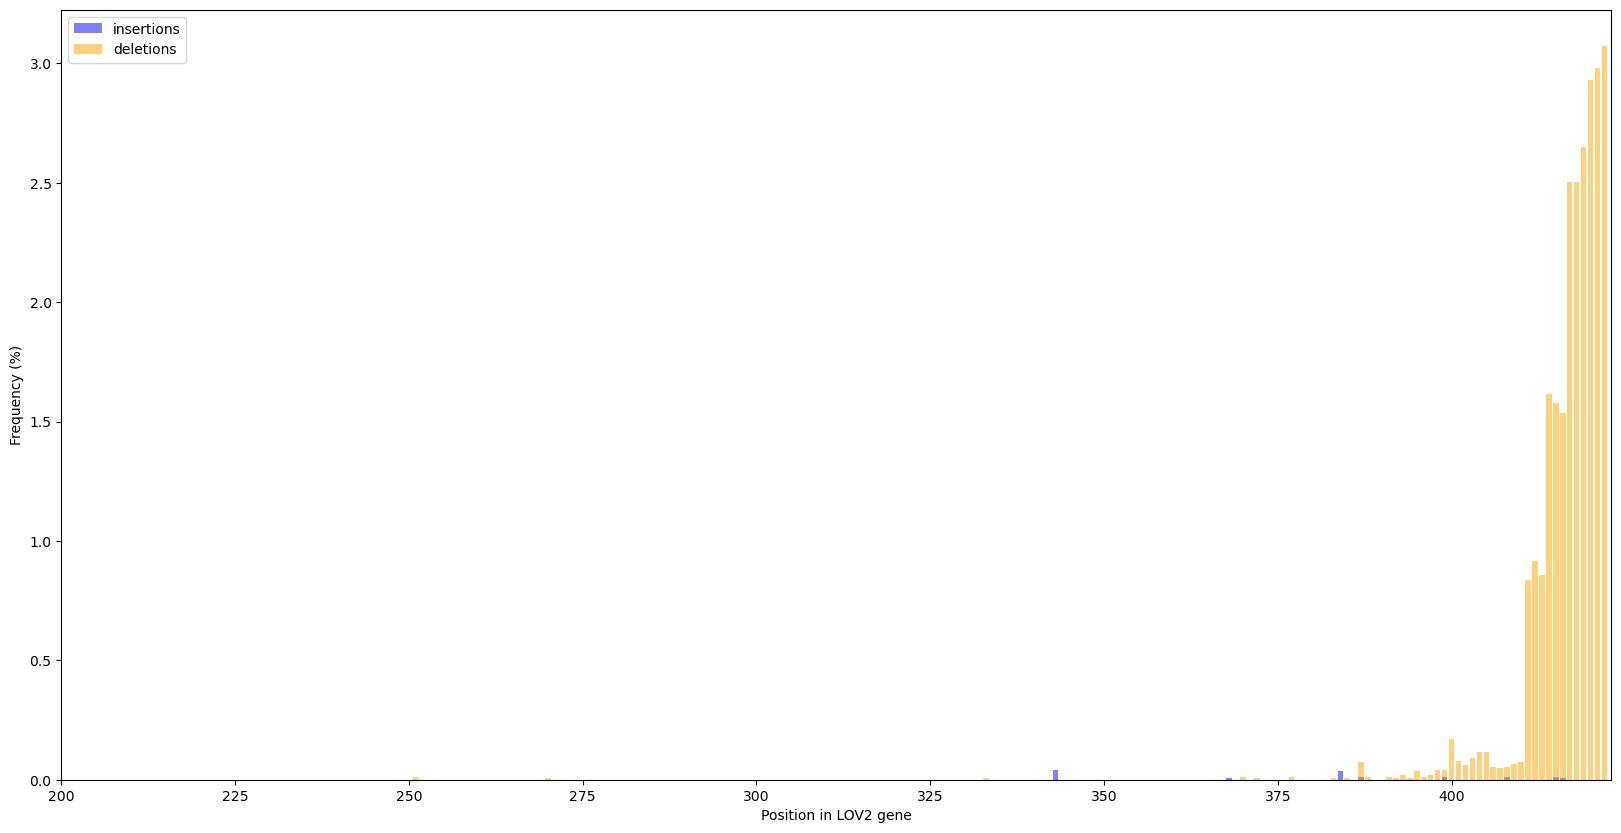

In [87]:
plt.figure(figsize=(20,10))
plt.bar(indels_freq.columns, indels_freq.loc["insertion"]*100, color = "blue", alpha = 0.5, label = "insertions")
plt.bar(indels_freq.columns, indels_freq.loc["deletion"]*100, color = "orange", alpha = 0.5, label = "deletions")
plt.legend()
if read_dir == "R1":
    plt.xlim(0,250)
else: 
    plt.xlim(200,len(LOV2_gene))
plt.ylabel("Frequency (%)")
plt.xlabel("Position in LOV2 gene")
plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_indel_distribution.pdf", bbox_inches="tight")
plt.show()

In [41]:
# enrichment_relative_BC1 = enrichment_relative_1.copy()
# enrichment_relative_BC2 = enrichment_relative.copy()
# enrichment_BC2_vs_BC1 = enrichment_relative_BC2 - enrichment_relative_BC1

# plot_mutation_enrichment(variants_df=enrichment_BC2_vs_BC1, ref_seq=LOV2_prot[:enrichment_df.shape[1]], cmap = "coolwarm")

In [9]:
linkers = get_linker_variants_from_blast_alignment(linker_alignments,wt_linker = "SG" if read_dir=="R1" else "GS",read_dir=read_dir)

363 reads excluded due to frameshifts


In [10]:
## sort linkers by frequency

linkers_sorted = {k: v for k, v in sorted(linkers.items(), key=lambda item: item[1], reverse=True)}
total_reads = sum(linkers_sorted.values())
linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

# exclude wt: 
linkers_sorted_perc.pop("wt")
linkers_perc_filt = {k: v for k, v in linkers_sorted_perc.items() if v > 0.05}

In [11]:
sum(linkers_perc_filt.values())

37.679172379409195

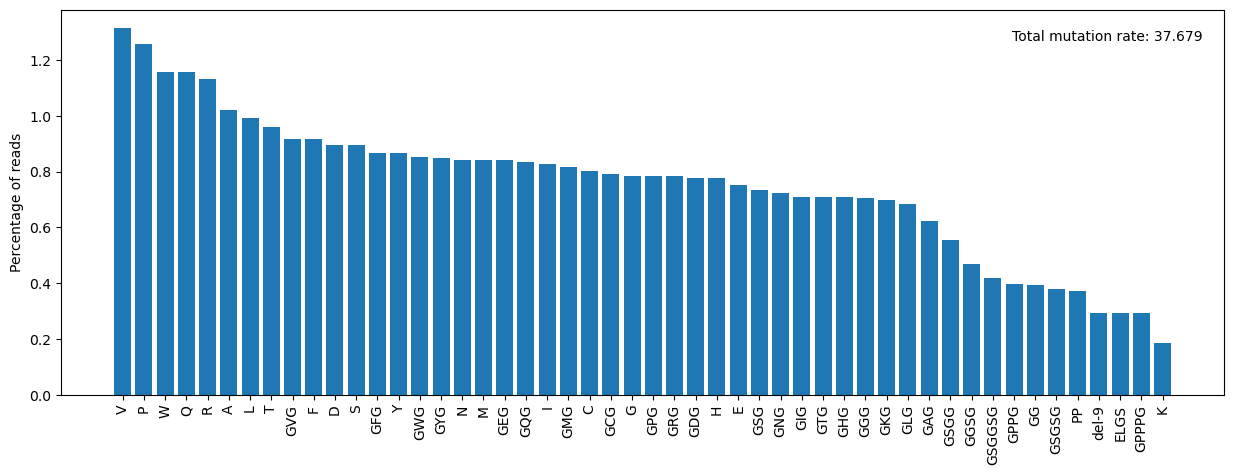

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

In [92]:
linker_variants_perc = pd.DataFrame.from_dict(linkers_perc_filt, orient = "index").T
linker_variants_perc.index =[  "observed"]

In [93]:
linker_variants_perc.to_csv(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.csv")